In [1]:
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt
%matplotlib inline

import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

import itertools
import warnings
warnings.filterwarnings('ignore')

Using TensorFlow backend.


In [0]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

def root_mean_squared_error(y_true, y_pred):
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    return rmse

In [0]:
original_data = np.genfromtxt('DAT_MT_EURUSD_M1_2019.csv', delimiter=',')
original_data = original_data[1::60,2]
length_data = len(original_data)

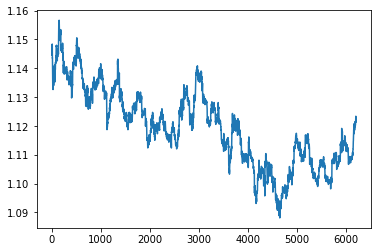

In [4]:
plt.plot(original_data)

In [0]:
def get_combinations(parameters):
    return list(itertools.product(*parameters))

In [0]:
def create_NN(input_nodes, hidden_nodes, output_nodes):
    model = Sequential()
    for k in range(4):
      model.add(Dense(int(hidden_nodes), input_dim=int(input_nodes)))
    model.add(Dense(int(output_nodes)))

    model.compile(loss='mean_squared_error', optimizer='adam')
    return model

In [0]:
def train_model(model, X_train, y_train, epochs, batch_size):
    model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, verbose=0, shuffle=False)
    return model

In [0]:
def reshape_arrays(X_train, y_train):
    X_train = np.array(X_train)
    y_train = np.reshape(y_train, (len(y_train), 1))
    return X_train, y_train

In [0]:
def preprocess_TLNN(data, time_lagged_points):
    data = np.array(data)[:, 0]
    X_train = []
    y_train = []
    for i in range(max(time_lagged_points), data.shape[0]):
        x = [data[i-p] for p in time_lagged_points]
        y = data[i]
        X_train.append(list(x))
        y_train.append(y)
    return X_train, y_train

In [0]:
def forecast_TLNN(model, time_lagged_points, last_sequence, future_steps):
    forecasted_values = []
    max_lag = max(time_lagged_points)
    for i in range(future_steps):
        input_sequence = [last_sequence[max_lag - p] for p in time_lagged_points]
        forecasted_value = model.predict(np.reshape(input_sequence, (1, len(input_sequence))))
        forecasted_values.append(forecasted_value[0][0])
        last_sequence = last_sequence[1:] + [forecasted_value[0][0]]
    return forecasted_values

In [0]:
def TLNN(data, time_lagged_points, hidden_nodes, output_nodes, epochs, batch_size, future_steps, scaler):
    # data = scaler.transform(data)
    X_train, y_train = preprocess_TLNN(data, time_lagged_points)
    X_train, y_train = reshape_arrays(X_train, y_train)
    model_TLNN = create_NN(input_nodes=len(time_lagged_points), hidden_nodes=hidden_nodes, output_nodes=output_nodes)
    model_TLNN = train_model(model_TLNN, X_train, y_train, epochs, batch_size)

    max_lag = max(time_lagged_points)
    forecasted_values_TLNN = forecast_TLNN(model_TLNN, time_lagged_points, 
                                      list(data[-max_lag:]), future_steps=future_steps)
    # forecasted_values_TLNN = list(scaler.inverse_transform([forecasted_values_TLNN])[0])
    
    return model_TLNN, forecasted_values_TLNN

In [0]:
def get_accuracies_TLNN(train_data, test_data, parameters, scaler):
    combination_of_params = get_combinations(parameters)
    information_TLNN = []
    iterator = 0
    print('TLNN - Number of combinations: ' + str(len(combination_of_params)))
    
    for param in combination_of_params:
        if (iterator+1) != len(combination_of_params):
            print(iterator+1, end=' -> ')
        else:
            print(iterator+1)
        iterator = iterator+1

        time_lagged_points = param[0]
        hidden_nodes = param[1]
        output_nodes = param[2]
        epochs = param[3]
        batch_size = param[4]
        future_steps = param[5]

        model_TLNN, forecasted_values_TLNN = TLNN(train_data, time_lagged_points, hidden_nodes,
                                                  output_nodes, epochs, batch_size, future_steps, scaler)
        
        y_true = test_data[:future_steps]
        y_pred = forecasted_values_TLNN
        rmse = np.sqrt(mean_squared_error(y_true, y_pred))
        
        info = list(param) + [rmse] + forecasted_values_TLNN
        information_TLNN.append(info)
        
    information_TLNN_df = pd.DataFrame(information_TLNN)
    indexes = [str(i) for i in list(range(1, future_steps+1))]
    information_TLNN_df.columns = ['look_back_lags', 'hidden_nodes', 'output_nodes', 'epochs', 'batch_size', 'future_steps','RMSE'] + indexes
    return information_TLNN_df

In [0]:
def analyze_results(data_frame, test_data, name, flag=False):
    optimized_params = data_frame.iloc[0]
    future_steps = optimized_params.future_steps
    forecast_values = optimized_params[-1*int(future_steps):]
    y_true = test_data[:int(future_steps)]

    model = create_NN(len(optimized_params.look_back_lags), optimized_params.hidden_nodes, 
                          optimized_params.output_nodes)
    s = ''
    for i in optimized_params.look_back_lags:
        s = s+' '+str(i)
    print('Look back lags: ' + s)
        
    print('Number of epochs: ' + str(optimized_params.epochs))
    print('Batch size: ' + str(optimized_params.batch_size))
    print('Number of future steps forecasted: ' + str(optimized_params.future_steps))
    print('Root Mean Squared Error(RMSE): ' + str(optimized_params.RMSE))
    print('\n\n')
    
    plt.figure(figsize=(14,5))
    plt.plot(y_true, color='green', label='Actual values')
    plt.plot(forecast_values, color='red', label='Forecasted values')
    plt.legend()
    return optimized_params

In [0]:
train_data = original_data[:int(10/12*length_data)]
train_data = train_data.reshape((len(train_data), 1))
test_data = original_data[int(10/12*length_data):]
test_data = test_data.reshape((len(test_data), 1))

In [0]:
output_nodes = 1
epochs = 5
batch_size = 20
future_steps = 50
tlp = [1,2,3,4,5,6,10,11,12]
# time_lagged_points, hidden_nodes, output_nodes, epochs, batch_size, future_steps
parameters_TLNN = [[tlp], [5], [output_nodes], [epochs], [batch_size], [future_steps]]

In [16]:
scaler = MinMaxScaler(feature_range=(0, 1))
scaler.fit(train_data)

MinMaxScaler(copy=True, feature_range=(0, 1))

TLNN - Number of combinations: 1
1
Look back lags:  1 2 3 4 5 6 10 11 12
Number of epochs: 5
Batch size: 20
Number of future steps forecasted: 50
Root Mean Squared Error(RMSE): 0.002529694003500197





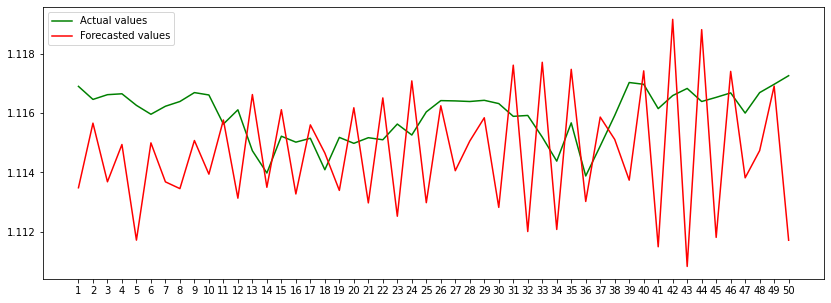

In [19]:
information_TLNN_df = get_accuracies_TLNN(train_data, test_data, parameters_TLNN, scaler)
optimized_params_TLNN = analyze_results(information_TLNN_df, test_data, 'TLNN')